Precision: 0.0333, Recall: 0.8849, F1-score: 0.0641


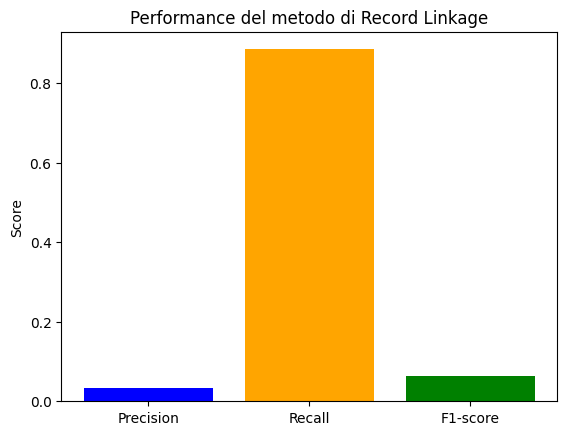

In [9]:
import pandas as pd
import recordlinkage
from recordlinkage import Compare
from recordlinkage.preprocessing import clean
from sklearn.metrics import precision_score, recall_score
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# Caricamento dataset
companies_df = pd.read_csv('../aziende_normalizzate.csv')
ground_truth = pd.read_csv('../ground_truth.csv')

# Pulizia del campo company_name
companies_df['company_name'] = clean(companies_df['company_name'])
companies_df['country'] = companies_df['country'].astype(str)

# Creazione dell'indice di coppie candidate
indexer = recordlinkage.Index()
indexer.sortedneighbourhood(left_on='company_name', window=5)
candidate_pairs = indexer.index(companies_df)

# Creazione MultiIndex
candidate_pairs_index = pd.MultiIndex.from_tuples(candidate_pairs, names=['left', 'right'])

# Creazione del comparatore
compare = Compare()
compare.string('company_name', 'company_name', method='jarowinkler', threshold=0.7, label='name_similarity')
compare.string('country', 'country', method='jarowinkler', threshold=0.75, label='country_similarity')

# Computazione similarità
features = compare.compute(candidate_pairs_index, companies_df)

# Identificazione delle coppie corrispondenti
matches = features[(features['name_similarity'] >= 0.7) & (features['country_similarity'] >= 0.75)]

# Creazione gruppi di aziende duplicate
detected_groups = defaultdict(set)
for left, right in matches.index:
    detected_groups[companies_df.loc[left, 'company_name']].add(companies_df.loc[right, 'company_name'])
    detected_groups[companies_df.loc[right, 'company_name']].add(companies_df.loc[left, 'company_name'])

detected_groups_list = [set([key] + list(values)) for key, values in detected_groups.items()]

# Creazione gruppi dalla ground truth
ground_truth_groups = defaultdict(set)
for _, row in ground_truth.iterrows():
    ground_truth_groups[row['c1.company_name']].add(row['c2.company_name'])
    ground_truth_groups[row['c2.company_name']].add(row['c1.company_name'])

ground_truth_sets = [set([key] + list(values)) for key, values in ground_truth_groups.items()]

# Funzione di valutazione
def evaluate_linkage(detected_groups, ground_truth_groups):
    true_positives = sum(1 for dg in detected_groups if any(dg & gt for gt in ground_truth_groups))
    false_positives = sum(1 for dg in detected_groups if not any(dg & gt for gt in ground_truth_groups))
    false_negatives = sum(1 for gt in ground_truth_groups if not any(gt & dg for dg in detected_groups))
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1_score

# Calcolo metriche di valutazione
precision, recall, f1_score = evaluate_linkage(detected_groups_list, ground_truth_sets)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1_score:.4f}")

# Visualizzazione grafica
labels = ["Precision", "Recall", "F1-score"]
values = [precision, recall, f1_score]

fig, ax = plt.subplots()
ax.bar(labels, values, color=['blue', 'orange', 'green'])
ax.set_ylabel("Score")
ax.set_title("Performance del metodo di Record Linkage")
plt.show()